In [1]:
from * import plotting_heatmap_functions as pfn

In [2]:
import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt

In [75]:
# Importing day 1 depletion in ESCs DEGS

proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

feature_counts = '20220816_featureCounts.csv'

In [76]:
day1_res_df = pd.read_csv(proj+day1_sigRes)

In [77]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332
...,...,...,...,...,...
1614,ENSMUSG00000020826.9,Nos2,3.533920,7.987690e-04,9.674001
1615,ENSMUSG00000010080.15,Epn3,3.822547,2.040000e-08,18.206916
1616,ENSMUSG00000061353.11,Cxcl12,4.706828,1.610000e-05,9.619308
1617,ENSMUSG00000036744.13,Olfr701,5.052035,1.740000e-05,11.999807


importing the rest of the feature counts to collect the set of non-significantly DE genes

In [78]:
feat_counts_df = pd.read_csv(proj+feature_counts)

In [79]:
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

In [80]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332
...,...,...,...,...,...
55416,ENSMUSG00000095523.1,NaN,NaN,NaN,NaN
55417,ENSMUSG00000095475.1,NaN,NaN,NaN,NaN
55418,ENSMUSG00000094855.1,NaN,NaN,NaN,NaN
55419,ENSMUSG00000095019.1,NaN,NaN,NaN,NaN


Getting the TSSes 

Note: assuming that the RNA-seq alignment is still being done via STAR method from 

In [81]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [82]:
# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrX'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrY'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrM'))]
tss_df =tss_df.loc[True==tss_df['chrom'].str.contains('chr')]
after = len(tss_df)

In [83]:
tss_df['chrom'].value_counts()

chr7     12506
chr2     10932
chr5      9006
chr11     8700
chr1      8579
chr9      8080
chr6      7888
chr4      7640
chr17     7098
chr3      6977
chr10     6605
chr8      6455
chr14     5873
chr13     5644
chr12     5371
chr15     5157
chr16     4514
chr19     4339
chr18     3573
Name: chrom, dtype: int64

In [84]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

In [85]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332
...,...,...,...,...,...
55416,ENSMUSG00000095523.1,NaN,NaN,NaN,NaN
55417,ENSMUSG00000095475.1,NaN,NaN,NaN,NaN
55418,ENSMUSG00000094855.1,NaN,NaN,NaN,NaN
55419,ENSMUSG00000095019.1,NaN,NaN,NaN,NaN


In [86]:
ts_intervals

,gene_id,chrom,start,end
0,ENSMUSG00000102693.1,chr1,3073252,3073252
1,ENSMUSG00000064842.1,chr1,3102015,3102015
2,ENSMUSG00000051951.5,chr1,3216345,3216345
5,ENSMUSG00000102851.1,chr1,3252756,3252756
6,ENSMUSG00000103377.1,chr1,3368550,3368550
...,...,...,...,...
134932,ENSMUSG00000117740.1,chr19,61232927,61232927
134933,ENSMUSG00000117782.1,chr19,61255966,61255966
134934,ENSMUSG00000117951.1,chr19,61257790,61257790
134935,ENSMUSG00000095993.1,chr19,61297070,61297070


In [87]:
# drop gene from data field if there is no change associated
# day1_res_df.dropna(subset=['log2FoldChange'], inplace=True)
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

In [88]:
day1_res_df.head(3)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,gene_id,chrom,start,end
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735,ENSMUSG00000025128.7,chr3,18054173.0,18054173.0
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503,ENSMUSG00000051314.11,chr7,30823776.0,30823776.0
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936,ENSMUSG00000057182.15,chr2,65567493.0,65567493.0


In [89]:
# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes: 
lost:  55


In [98]:
day1_res_df['log2FoldChange'].tail(1).isna()

51164    True
Name: log2FoldChange, dtype: bool

In [103]:
def label_DE_status_deseq2(gene_row):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    return 'nonsig'

In [104]:
day1_res_df['DE_status'] = day1_res_df.apply(lambda row: label_DE_status_deseq2(row), axis=1)

In [105]:
day1_res_df.tail(3)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,gene_id,chrom,start,end,DE_status
51162,ENSMUSG00000117951.1,NaN,NaN,NaN,NaN,ENSMUSG00000117951.1,chr19,61257790.0,61257790.0,nonsig
51163,ENSMUSG00000095993.1,NaN,NaN,NaN,NaN,ENSMUSG00000095993.1,chr19,61297070.0,61297070.0,nonsig
51164,ENSMUSG00000118197.1,NaN,NaN,NaN,NaN,ENSMUSG00000118197.1,chr19,61305281.0,61305281.0,nonsig


Where is ChIP relative to dysregulated genes? 

Interesting proteins: For Rad21? For CTCF? For Nipbl? Polycomb proteins (RING1B, SUZ12)?

In [106]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [107]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

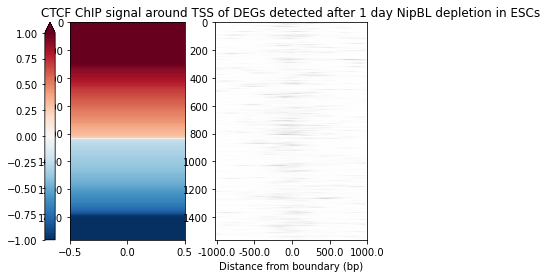

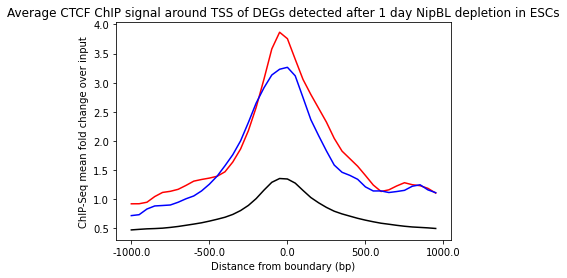

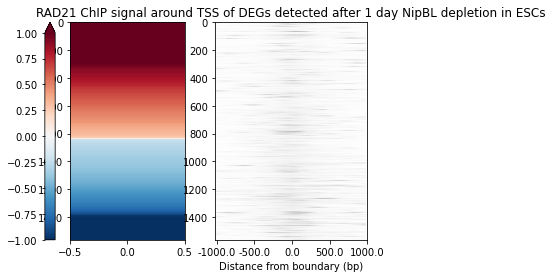

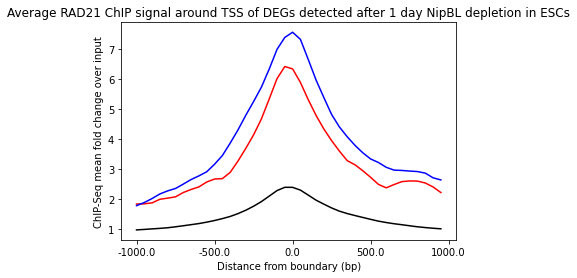

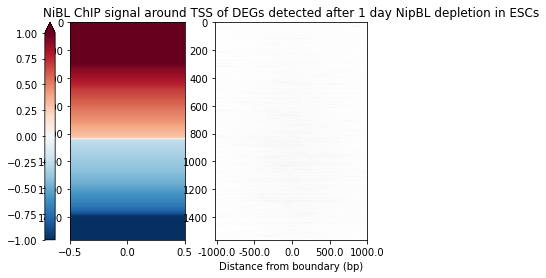

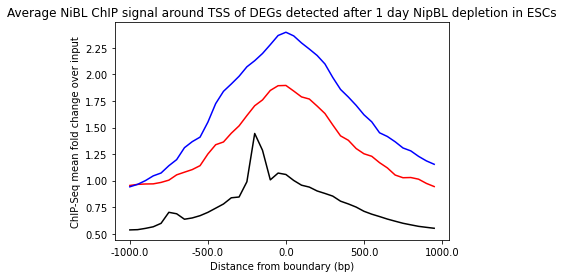

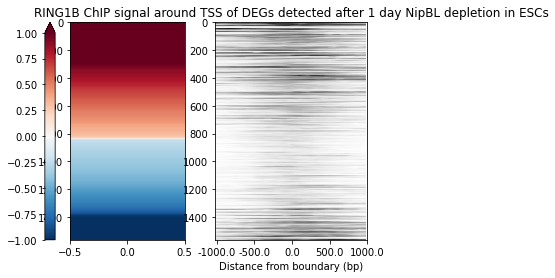

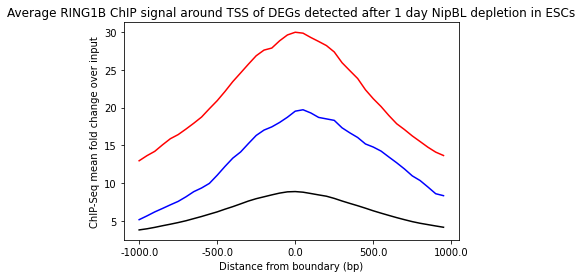

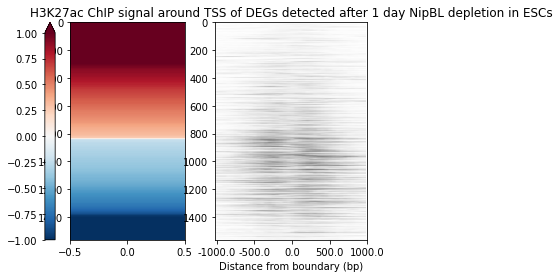

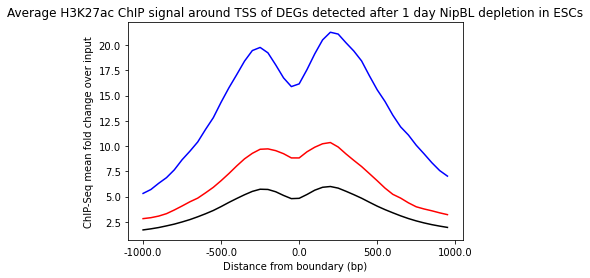

In [111]:
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=1000, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'])
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond))
    
    plt.show()


In [112]:
matrix

array([[ 0.        ,  0.08058986,  0.29136333, ..., 16.54881935,
        19.54063469, 15.64713219],
       [ 1.13921886,  0.58733138,  1.19336344, ...,  6.21144714,
         3.13467226,  1.53320747],
       [ 1.15379162,  0.90308119,  0.83807313, ...,  0.33769425,
         1.03921057,  1.12370811],
       ...,
       [ 0.33105299,  0.26484259,  0.92694702, ...,  0.5551688 ,
         0.5551688 ,  0.1239844 ],
       [ 0.18597659,  0.30996099,  0.0619922 , ...,  0.51200002,
         0.30720001,  0.51200002],
       [ 0.        ,  0.        ,  0.        , ...,  0.27146345,
         0.33105299,  0.75751406]])

In [123]:
np.max(matrix)

149.39382629394532

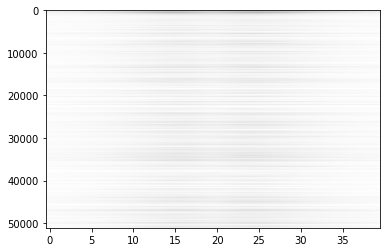

In [124]:
ax = plt.subplot()
ax.imshow(matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)

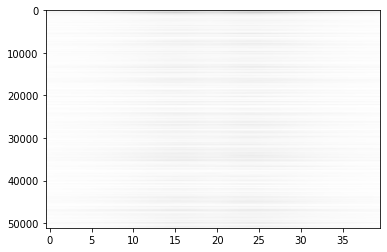

In [126]:
ax = plt.subplot()
ax.imshow(matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=np.max(matrix))

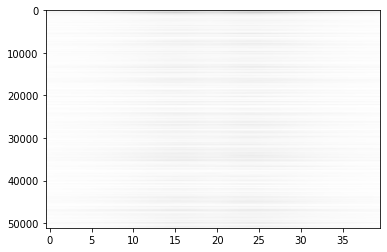

In [127]:
ax = plt.subplot()
ax.imshow(matrix, cmap='gray_r', aspect='auto')

### Extending window to +/- 100kbp

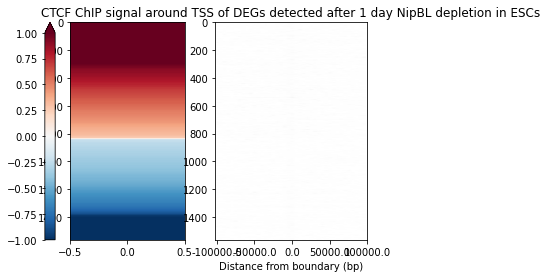

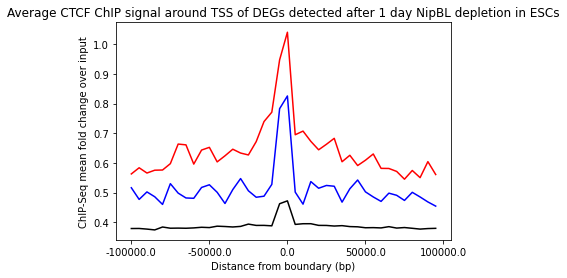

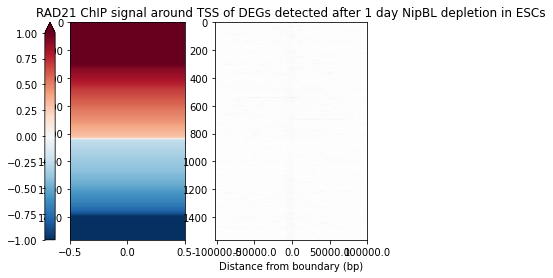

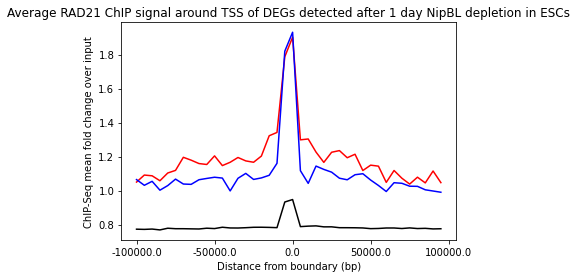

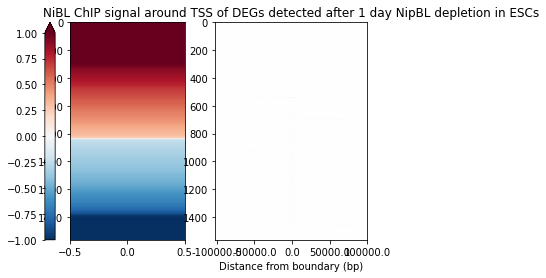

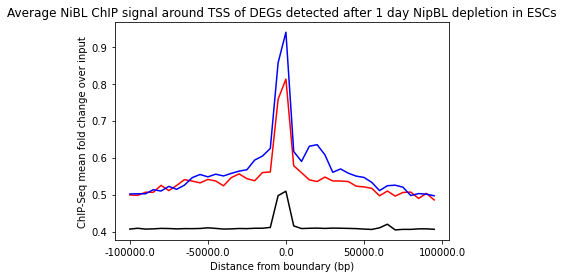

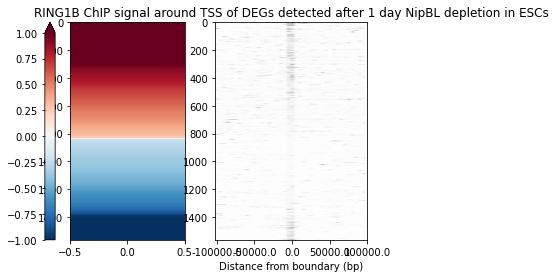

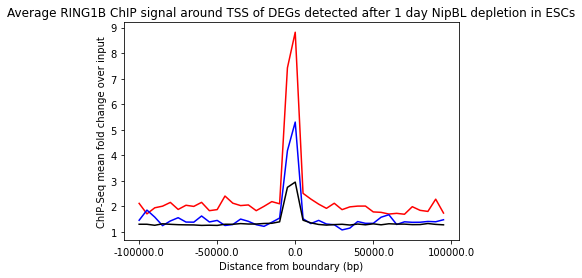

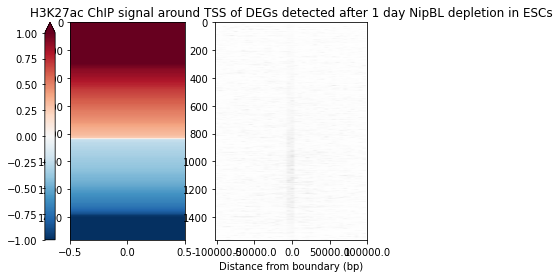

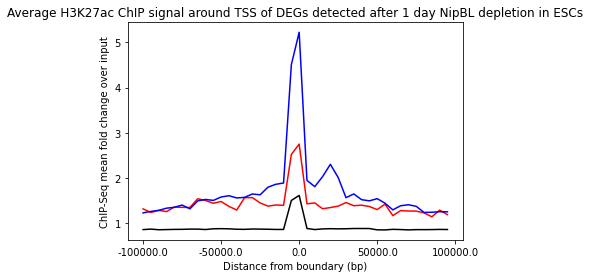

In [109]:
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=100000, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'],
                            windowSize=100000,
                              nbins=40)
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                   windowSize=100000,
                   nbins=40)
    
    plt.show()

### Window +/- 10kbp

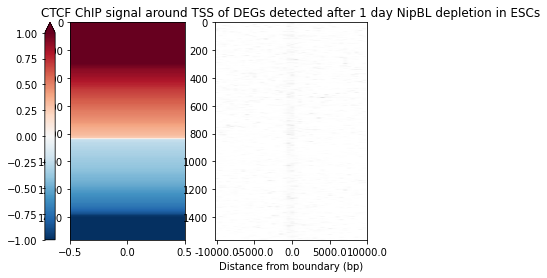

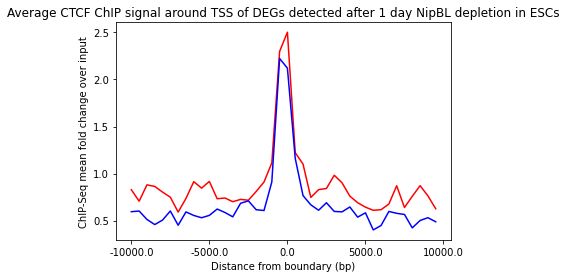

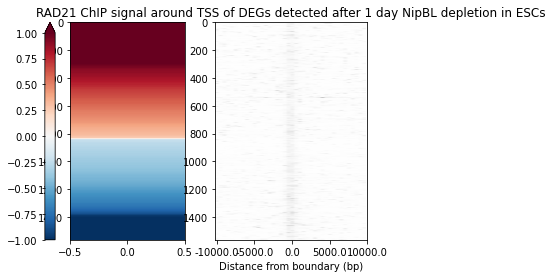

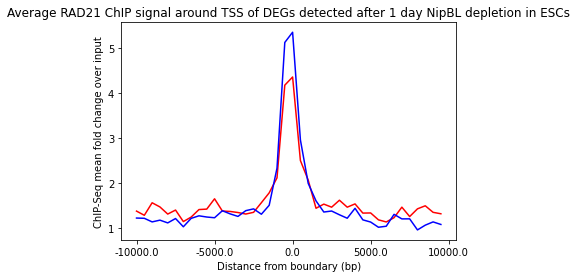

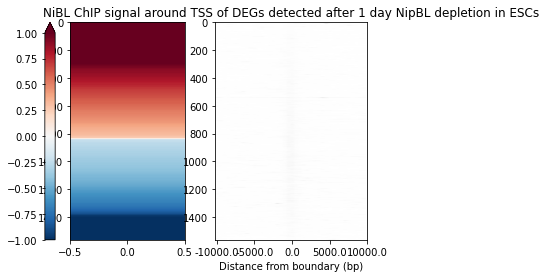

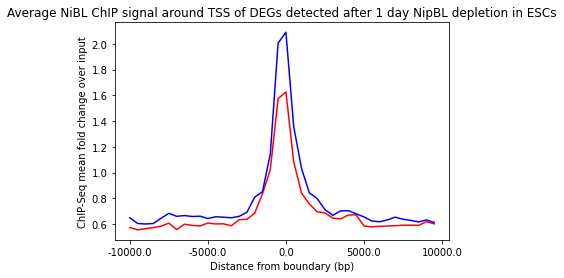

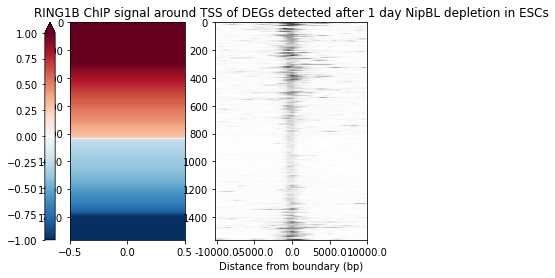

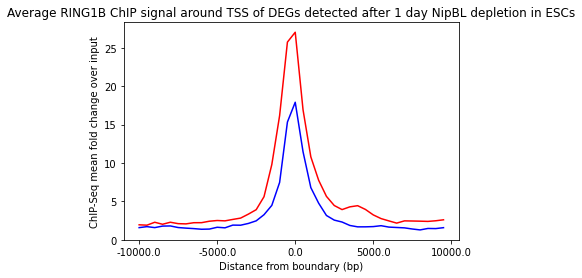

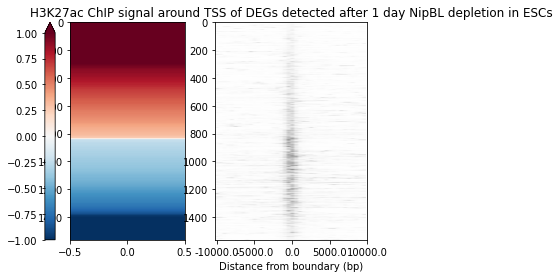

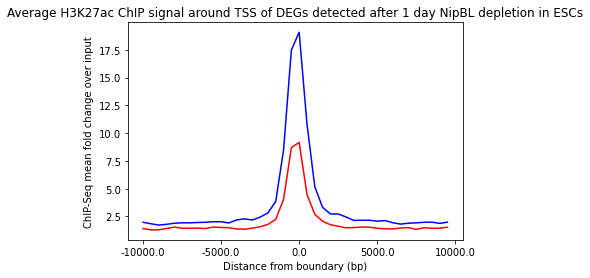

In [110]:
window = 10000
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=window, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'],
                            windowSize=window,
                              nbins=40)
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                    agg_categories=['up', 'down'],
                   windowSize=window,
                   nbins=40)
    
    plt.show()